Still need to figure out:
-calculate trunk angles
-create graph of moving pose estimation
-make squat events

In [1]:
!pip install mediapipe opencv-python

In [2]:
import cv2
import mediapipe as mp
import numpy as np
from matplotlib import pyplot as plt
import typing as tp
mp_drawing = mp.solutions.drawing_utils
mp_pose = mp.solutions.pose

In [3]:
file_name = 'Seth_Barbell_Squat_1.MP4.MP4'
window_name = "window"
interframe_wait_ms = 30

In [4]:
#finds frame rate of video
cam = cv2.VideoCapture('Seth_Barbell_Squat_1.MP4.MP4')
fps = cam.get(cv2.CAP_PROP_FPS)
fps = round(fps, 0)
print(fps)

60.0


In [5]:
def calculate_angle(a,b,c):
    a = np.array(a) # First
    b = np.array(b) # Mid
    c = np.array(c) # End
    
    radians = np.arctan2(c[1]-b[1], c[0]-b[0]) - np.arctan2(a[1]-b[1], a[0]-b[0])
    angle = np.abs(radians*180.0/np.pi)
    
    if angle >180.0:
        angle = 360-angle
        
    return angle 

In [6]:
Hip_Angles = []
Knee_Angles = []
Ankle_Angles = []

In [77]:
RShoulder_Cord = []
RHip_Cord = []
RKnee_Cord = []
RAnkle_Cord = []
RToe_Cord = []

In [94]:
cap = cv2.VideoCapture(file_name)
if not cap.isOpened():
    print("Error: Could not open video.")
    exit()

cv2.namedWindow(window_name, cv2.WND_PROP_FULLSCREEN)
cv2.setWindowProperty(window_name, cv2.WND_PROP_FULLSCREEN, cv2.WINDOW_FULLSCREEN)

frame_width = int(cap.get(3))
frame_height = int(cap.get(4))

size = (frame_width, frame_height)

Save_Video= cv2.VideoWriter('output.avi',
                         cv2.VideoWriter_fourcc(*'MJPG'),
                         10, size)

## Setup mediapipe instance
with mp_pose.Pose(min_detection_confidence=0.5, min_tracking_confidence=0.5) as pose:
    while (True):
        ret, frame = cap.read()
        if not ret:
            print("Reached end of video, exiting.")
            break
        
        # Recolor image to RGB
        image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        image.flags.writeable = False
      
        # Make detection
        results = pose.process(image)
    
        # Recolor back to BGR
        image.flags.writeable = True
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
        
        # Extract landmarks
        try:
            landmarks = results.pose_landmarks.landmark
            
            # Get coordinates
            RShoulder = [landmarks[mp_pose.PoseLandmark.RIGHT_SHOULDER.value].x,landmarks[mp_pose.PoseLandmark.RIGHT_SHOULDER.value].y]
            RHip = [landmarks[mp_pose.PoseLandmark.RIGHT_HIP.value].x,landmarks[mp_pose.PoseLandmark.RIGHT_HIP.value].y]
            RKnee = [landmarks[mp_pose.PoseLandmark.RIGHT_KNEE.value].x,landmarks[mp_pose.PoseLandmark.RIGHT_KNEE.value].y]
            RAnkle = [landmarks[mp_pose.PoseLandmark.RIGHT_ANKLE.value].x,landmarks[mp_pose.PoseLandmark.RIGHT_ANKLE.value].y]
            RToe = [landmarks[mp_pose.PoseLandmark.RIGHT_FOOT_INDEX.value].x,landmarks[mp_pose.PoseLandmark.RIGHT_FOOT_INDEX.value].y]
            
            RShoulder_Cord.append(RShoulder)
            RHip_Cord.append(RHip)
            RKnee_Cord.append(RKnee)
            RAnkle_Cord.append(RAnkle)
            RToe_Cord.append(RToe)
            
            # Calculate angle
            Hip_Angle = calculate_angle(RShoulder, RHip, RKnee)
            Knee_Angle = calculate_angle(RHip, RKnee, RAnkle)
            Ankle_Angle = calculate_angle(RKnee, RAnkle, RToe)
            Hip_Angles.append(Hip_Angle)
            Knee_Angles.append(Knee_Angle)
            Ankle_Angles.append(Ankle_Angle)
                
            # Visualize angle
            cv2.putText(image, str(Hip_Angle), 
                           tuple(np.multiply(RHip, [image.shape[1], image.shape[0]]).astype(int)), 
                           cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2, cv2.LINE_AA
                                )
            # Visualize angle
            cv2.putText(image, str(Knee_Angle), 
                           tuple(np.multiply(RKnee, [image.shape[1], image.shape[0]]).astype(int)), 
                           cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2, cv2.LINE_AA
                                )
            # Visualize angle
            cv2.putText(image, str(Ankle_Angle), 
                           tuple(np.multiply(RAnkle, [image.shape[1], image.shape[0]]).astype(int)), 
                           cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2, cv2.LINE_AA
                                )
                       
        except:
            pass
        
        # Render detections
        mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_pose.POSE_CONNECTIONS,
                                mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=2), 
                                mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2) 
                                 )               
        
        Save_Video.write(image) #saves video with pose estimation
        
        cv2.imshow(window_name, image)
        
        if ret == True:
            cv2.namedWindow("window", cv2.WND_PROP_FULLSCREEN)
            cv2.setWindowProperty("window",cv2.WND_PROP_FULLSCREEN,
                    cv2.WINDOW_FULLSCREEN)
            if cv2.waitKey(30) & 0xFF == ord('q'):
                print("Exit requested")
                break

    cap.release()
    cv2.destroyAllWindows()

Exit requested


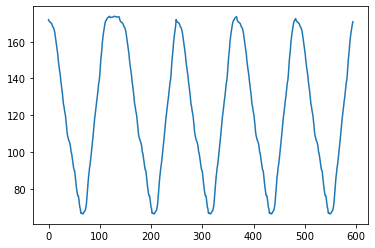

In [96]:
#print(Hip_Angles)
plt.plot(Hip_Angles)
plt.show()

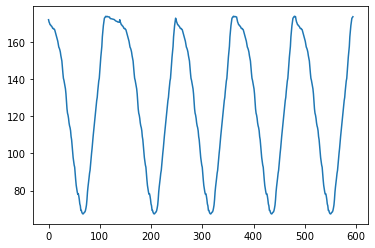

In [97]:
#print(Knee_Angles)
plt.plot(Knee_Angles)
plt.show()

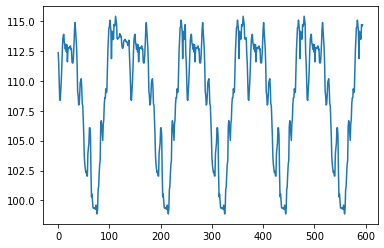

In [98]:
#print(Ankle_Angles)
plt.plot(Ankle_Angles)
plt.show()

In [ ]:
from scipy.signal import butter, filtfilt, freqz, iirnotch

In [ ]:
def butter_lowpass(cutoff, fs, order = 2):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

In [ ]:
def butter_highpass(cutoff, fs, order = 2):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='high', analog=False)
    return b, a

In [ ]:
def butter_bandpass(cutoff, fs, order = 2):
    nyq = 0.5 * fs
    low_normal_cutoff = lowcutoff / nyq
    high_normal_cutoff = highcutoff / nyq
    b, a = butter(order, [low_normal_cutoff, high_normal_cutoff], btype='band')
    return b, a

In [ ]:
order = 2
fs = fps       
cutoff = 6  

In [ ]:
b,a = butter_lowpass(cutoff, fs, order=order)

In [ ]:
b,a = butter_highpass(cutoff, fs, order=order)

In [ ]:
Hip_Angles_Filtered = filtfilt(b,a,Hip_Angles)
Knee_Angles_Filterd = filtfilt(b,a,Knee_Angles)
Ankle_Angles_Filtered = filtfilt(b,a,Ankle_Angles)

In [ ]:
plt.plot(Hip_Angles_Filtered,'y', linewidth=2)
plt.plot(Hip_Angles, 'b-', label='data')
plt.title("Filtered Hip Kinematics")
plt.legend(["filtered data","raw data"])
plt.show()

In [ ]:
plt.plot(Knee_Angles_Filterd,'y', linewidth=2)
plt.plot(Knee_Angles, 'b-', label='data')
plt.title("Filtered Knee Kinematics")
plt.legend(["filtered data","raw data"])
plt.show()

In [ ]:
plt.plot(Ankle_Angles_Filtered,'y', linewidth=2)
plt.plot(Ankle_Angles, 'b-', label='data')
plt.title("Filtered Ankle Kinematics")
plt.legend(["filtered data","raw data"])
plt.show()